In [1]:
from functools import partial
import json
import os
import sys
import random
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from gerrychain import (
    Election,
    GeographicPartition,
    Graph,
    MarkovChain,
    Partition,
    accept, 
    constraints,
    updaters
)

from gerrychain.tree import (
    recursive_tree_part, 
    bipartition_tree_random, 
    PopulatedGraph,
    contract_leaves_until_balanced_or_none,  
    find_balanced_edge_cuts
    #NOTE: contract_leaves_until_balanced_or_none 
    #and find_balanced_edge_cuts need to be added manually to /gerrychain/tree.py
)

from gerrychain.proposals import recom, propose_random_flip
from gerrychain.metrics import polsby_popper
from gerrychain.updaters import cut_edges, county_splits, Tally
from networkx.algorithms import tree

sns.set(style="white", palette="muted", color_codes=True)

In [2]:
github_file_path = str(Path(os.getcwd())) #Sets to local Github directory path

sys.path.insert(1, github_file_path) 

github_file_path

'/Users/katherinechang/RedistrictingCT'

In [3]:
ct_graph_house = Graph.from_json("./data/CT_dual_graph.json")
ct_df_house = gpd.read_file("./data/CT_analysis.zip")

/Users/katherinechang/opt/anaconda3/envs/gerrychain/lib/python3.9/site-packages/gerrychain/graph/graph.py:238: UserWarning: Found islands (degree-0 nodes). Indices of islands: {36463}
  warnings.warn(


In [4]:
#Drop island
ct_graph_house.remove_node(36463)
ct_df_house = ct_df_house.drop(index=36463)

# Connecticut State House of Representatives

In [5]:
#issue with duplicate, two incumbents live on the same block
#33614, incumbent for ct_house 
#33615 incumbent for ct_sen

#Drop incumbent for ct_sen

ct_graph_house.remove_node(33615)
ct_df_house = ct_df_house.drop(index=33615)

### Updaters

In [6]:
totpop = "VAP"
dist_num_cthouse = 151

def num_splits_house(partition, df=ct_df_house):
    df["current"] = df.index.map(partition.assignment)
    return sum(df.groupby("town")["current"].nunique() > 1)

def num_incumbents_house(partition, df=ct_df_house):
    df["current"] = df.index.map(partition.assignment)
    df['current'] = df['current'].astype(str).replace('\.0', '', regex=True)
    df["incumbent_chamber"] = 0
    df.loc[(df['chamber'] == 'ct_house') & (df['INCUMBENT'] == 1), 
           'incumbent_chamber'] = 1
    incum_numby_dist = df.groupby("current")["incumbent_chamber"].sum().value_counts()
    return incum_numby_dist.sort_index()

updater_house = {
    "population": Tally(totpop, alias="population"),
    "cut_edges": cut_edges,
    "town_splits": num_splits_house,
    "incumbent": num_incumbents_house
}

total_population = sum([ct_graph_house.nodes[n][totpop] for n in ct_graph_house.nodes])

### 2021 House Plan Analysis

In [7]:
partition_2021_house = Partition(ct_graph_house,
                                 ct_df_house["HOUSE"], 
                                 updater_house)

In [8]:
metric_results_house={}

for name, func in partition_2021_house.updaters.items():
    metric_results_house[name] = partition_2021_house[name]

In [9]:
print(metric_results_house["town_splits"]) #72 town splits out of 169 unique towns

print(100*round(metric_results_house["town_splits"]/ct_df_house["town"].nunique(), 5), "%") #42% towns are split

print(100*round(metric_results_house["incumbent"][1]/metric_results_house["incumbent"].sum(), 5), "%") 
#97.35% of CT House with a single pre-2021 incumbents in a redistricted district

72
42.604 %
97.351 %


### Constraints and Acceptance Functions

In [10]:
def get_spanning_tree_u_w(G):
    node_set=set(G.nodes())
    x0=random.choice(tuple(node_set))
    x1=x0
    while x1==x0:
        x1=random.choice(tuple(node_set))
    node_set.remove(x1)
    tnodes ={x1}
    tedges=[]
    current=x0
    current_path=[x0]
    current_edges=[]
    while node_set != set():
        next=random.choice(list(G.neighbors(current)))
        current_edges.append((current,next))
        current = next
        current_path.append(next)
        if next in tnodes:
            for x in current_path[:-1]:
                node_set.remove(x)
                tnodes.add(x)
            for ed in current_edges:
                tedges.append(ed)
            current_edges = []
            if node_set != set():
                current=random.choice(tuple(node_set))
            current_path=[current]
        if next in current_path[:-1]:
            current_path.pop()
            current_edges.pop()
            for i in range(len(current_path)):
                if current_edges !=[]:
                    current_edges.pop()
                if current_path.pop() == next:
                    break
            if len(current_path)>0:
                current=current_path[-1]
            else:
                current=random.choice(tuple(node_set))
                current_path=[current]
    #tgraph = Graph()
    #tgraph.add_edges_from(tedges)
    return G.edge_subgraph(tedges)

def my_uu_bipartition_tree_random(
    graph,
    pop_col,
    pop_target,
    epsilon,
    node_repeats=1,
    spanning_tree=None,
    choice=random.choice):
    populations = {node: graph.nodes[node][pop_col] for node in graph}
    possible_cuts = []
    
    if spanning_tree is None:
        spanning_tree = get_spanning_tree_u_w(graph)
        
    while len(possible_cuts) == 0:
        for edge in graph.edges():
            if graph.nodes[edge[0]]["town"] == graph.nodes[edge[1]]["town"]:
                graph.edges[edge]["weight"] = 10 * random.random()
            else:
                graph.edges[edge]["weight"] = random.random()
        spanning_tree = tree.maximum_spanning_tree(graph, algorithm="kruskal", weight= "weight")
        #get_spanning_tree_u_w(graph)
        h = PopulatedGraph(spanning_tree, populations, pop_target, epsilon)
        possible_cuts = find_balanced_edge_cuts(h, choice=choice)
        
    return choice(possible_cuts).subset

In [11]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 1.5 * len(partition_2021_house["cut_edges"])
)

In [12]:
def town_accept(partition):
    if partition["town_splits"] < partition.parent["town_splits"]:
        return True
    else:
        if random.random() < .1:
            return True
        else:
            return False

In [13]:
ideal_population = sum(partition_2021_house["population"].values()) / len(partition_2021_house)

popbound = constraints.within_percent_of_ideal_population(partition_2021_house, 0.01)

### Ensemble

In [14]:
plan_neutral = recursive_tree_part(ct_graph_house, #graph object
                                range(dist_num_cthouse), #how many districts
                                total_population/dist_num_cthouse, #population target
                                totpop, #population column, variable name
                                .01, #epsilon value
                                1)

partition_neutral = Partition(ct_graph_house,
                              plan_neutral, 
                              updater_house)

In [15]:
tree_proposal = partial(
    recom, 
    pop_col=totpop, 
    pop_target=ideal_population, 
    epsilon=0.01, 
    node_repeats=1, 
    method =my_uu_bipartition_tree_random
) 

In [16]:
chain_seed_tree = MarkovChain(
    proposal=tree_proposal,
    constraints=[
        popbound,
        compactness_bound
    ],
    accept=town_accept, 
    initial_state=partition_neutral,
    total_steps=20000
)

In [17]:
incumbents_ensemble = []
splits_ensemble = []
t=0

for part in chain_seed_tree:
    splits_ensemble.append(part["town_splits"])
    incumbents_ensemble.append(part["incumbent"])

    t += 1
    if t % 200 == 0:
        print(t)
    if t%20000==0:
        t=0

200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800
12000
12200
12400
12600
12800
13000
13200
13400
13600
13800
14000
14200
14400
14600
14800
15000
15200
15400
15600
15800
16000
16200
16400
16600
16800
17000
17200
17400
17600
17800
18000
18200
18400
18600
18800
19000
19200
19400
19600
19800
20000


In [18]:
incumbent_ensemble_plot=[]
for n in range(len(incumbents_ensemble)):
    incumbent_ensemble_plot.append(incumbents_ensemble[n][1]/incumbents_ensemble[0].sum())

In [19]:
with open("./data/plot_incumbent_ensemble_house.json", "w") as incumbent_ensemble_house:
    json.dump(incumbent_ensemble_plot, incumbent_ensemble_house)

In [20]:
#incumbent_house_file = open("./data/plot_incumbent_ensemble_house.json")
#incumbent_ensemble_plot = json.loads(incumbent_house_file.read()) 

In [94]:
np.mean(incumbent_ensemble_plot)

0.5219668874172186

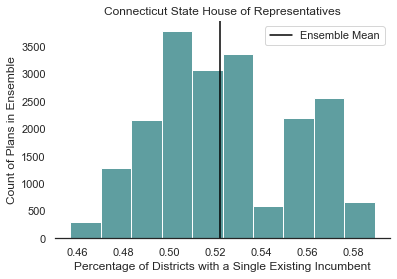

In [95]:
plt.hist(incumbent_ensemble_plot, bins=10, color="cadetblue")
plt.axvline(x=np.mean(incumbent_ensemble_plot),color="black", label ="Ensemble Mean")
plt.legend(loc="upper right")
plt.title("Connecticut State House of Representatives")
plt.xlabel("Percentage of Districts with a Single Existing Incumbent")
plt.ylabel("Count of Plans in Ensemble")
sns.despine(left=True, right=True)
plt.savefig("./outputs/ct_house_incumbents.png", dpi=300, facecolor='white', transparent=False)
plt.show()

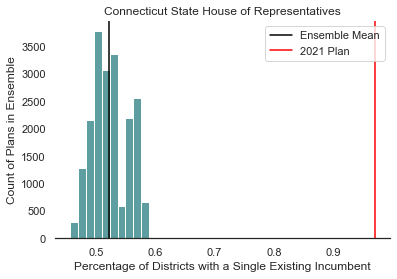

In [96]:
plt.hist(incumbent_ensemble_plot, bins=10, color="cadetblue")
plt.axvline(x=np.mean(incumbent_ensemble_plot),color="black", label ="Ensemble Mean")
plt.axvline(x=0.97,color="red", label="2021 Plan")
plt.legend(loc="upper right")
plt.title("Connecticut State House of Representatives")
plt.xlabel("Percentage of Districts with a Single Existing Incumbent")
plt.ylabel("Count of Plans in Ensemble")
sns.despine(left=True, right=True)
plt.savefig("./outputs/ct_house_incumbents_w2021.png", dpi=300, facecolor='white', transparent=False)
plt.show()

In [97]:
np.mean(splits_ensemble)

108.00585

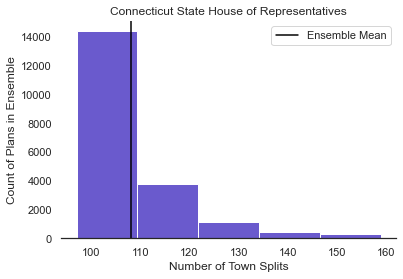

In [98]:
plt.hist(splits_ensemble, bins=5, color="slateblue")
plt.axvline(x=np.mean(splits_ensemble),color="black", label ="Ensemble Mean")
plt.title("Connecticut State House of Representatives")
plt.legend(loc="upper right")
plt.xlabel("Number of Town Splits")
plt.ylabel("Count of Plans in Ensemble")
sns.despine(left=True, right=True)
plt.savefig("./outputs/ct_house_town.png", dpi=300, facecolor='white', transparent=False)
plt.show()

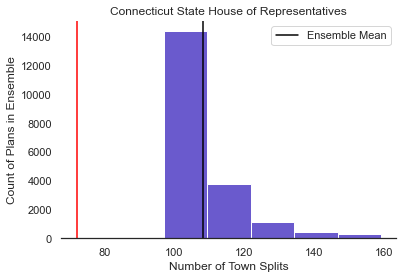

In [99]:
plt.hist(splits_ensemble, bins=5, color="slateblue")
plt.axvline(x=np.mean(splits_ensemble),color="black", label ="Ensemble Mean")
plt.axvline(x=72,color="red")
plt.legend(loc="upper right")
plt.title("Connecticut State House of Representatives")
plt.xlabel("Number of Town Splits")
plt.ylabel("Count of Plans in Ensemble")
sns.despine(left=True, right=True)
plt.savefig("./outputs/ct_house_town_w2021.png", dpi=300, facecolor='white', transparent=False)
plt.show()

# Connecticut State Senate

In [41]:
ct_graph_sen = Graph.from_json("./data/CT_dual_graph.json")
ct_df_sen = gpd.read_file("./data/CT_analysis.zip")

/Users/katherinechang/opt/anaconda3/envs/gerrychain/lib/python3.9/site-packages/gerrychain/graph/graph.py:238: UserWarning: Found islands (degree-0 nodes). Indices of islands: {36463}
  warnings.warn(


In [42]:
#Drop island
ct_graph_sen.remove_node(36463)
ct_df_sen = ct_df_sen.drop(index=36463)

In [43]:
ct_graph_sen.remove_node(33614)
ct_df_sen = ct_df_sen.drop(index=33614)

### Updaters

In [44]:
totpop = "VAP"
dist_num_ctsen = 36

def num_splits_sen(partition, df=ct_df_sen):
    df["current"] = df.index.map(partition.assignment)
    return sum(df.groupby("town")["current"].nunique() > 1)

def num_incumbents_sen(partition, df=ct_df_sen):
    df["current"] = df.index.map(partition.assignment)
    df['current'] = df['current'].astype(str).replace('\.0', '', regex=True)
    df["incumbent_chamber"] = 0
    df.loc[(df['chamber'] == 'ct_sen') & (df['INCUMBENT'] == 1), 
           'incumbent_chamber'] = 1
    incum_numby_dist = df.groupby("current")["incumbent_chamber"].sum().value_counts()
    return incum_numby_dist.sort_index()

updater_sen = {
    "population": Tally(totpop, alias="population"),
    "cut_edges": cut_edges,
    "town_splits": num_splits_sen,
    "incumbent": num_incumbents_sen
}

total_population = sum([ct_graph_sen.nodes[n][totpop] for n in ct_graph_sen.nodes])

### 2021 Senate Plan Analysis

In [45]:
partition_2021_sen = Partition(ct_graph_sen,
                               ct_df_sen["SENATE"], 
                               updater_sen)

In [46]:
metric_results_sen={}

for name, func in partition_2021_sen.updaters.items():
    metric_results_sen[name] = partition_2021_sen[name]

In [47]:
print(metric_results_sen["town_splits"]) #38 town splits out of 169 unique towns

print(100*round(metric_results_sen["town_splits"]/ct_df_sen["town"].nunique(), 5), "%") #22% towns are split

print(100*round(metric_results_sen["incumbent"][1]/metric_results_sen["incumbent"].sum(), 5), "%") 
#100% of CT Senate contain a single pre-2020 incumbent in a redistricted district

38
22.485 %
100.0 %


### Constraints and Acceptance Function

In [48]:
compactness_bound_sen = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 1.5 * len(partition_2021_sen["cut_edges"])
)

In [49]:
def town_accept_sen(partition):
    if partition["town_splits"] < partition.parent["town_splits"]:
        return True
    else:
        if random.random() < .1:
            return True
        else:
            return False

In [50]:
ideal_population_sen = sum(partition_2021_sen["population"].values()) / len(partition_2021_sen)

popbound_sen = constraints.within_percent_of_ideal_population(partition_2021_sen, 0.01)

### Ensemble

In [51]:
plan_neutral_sen = recursive_tree_part(ct_graph_sen, #graph object
                                range(dist_num_ctsen), #how many districts
                                total_population/dist_num_ctsen, #population target
                                totpop, #population column, variable name
                                .01, #epsilon value
                                1)

partition_neutral_sen = Partition(ct_graph_sen,
                              plan_neutral_sen, 
                              updater_sen)

In [52]:
tree_proposal_sen = partial(
    recom, 
    pop_col=totpop, 
    pop_target=ideal_population_sen, 
    epsilon=0.01, 
    node_repeats=1, 
    method =my_uu_bipartition_tree_random
) 

In [53]:
chain_seed_tree_sen = MarkovChain(
    proposal=tree_proposal_sen,
    constraints=[
        popbound_sen,
        compactness_bound_sen
    ],
    accept=town_accept_sen, 
    initial_state=partition_neutral_sen,
    total_steps=20000
)

In [54]:
incumbents_ensemble_sen = []
splits_ensemble_sen = []
t=0

for part in chain_seed_tree_sen:
    splits_ensemble_sen.append(part["town_splits"])
    incumbents_ensemble_sen.append(part["incumbent"])

    t += 1
    if t % 200 == 0:
        print(t)
    if t%20000==0:
        t=0

200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800
12000
12200
12400
12600
12800
13000
13200
13400
13600
13800
14000
14200
14400
14600
14800
15000
15200
15400
15600
15800
16000
16200
16400
16600
16800
17000
17200
17400
17600
17800
18000
18200
18400
18600
18800
19000
19200
19400
19600
19800
20000


In [55]:
incumbent_ensemble_sen_plot=[]
for n in range(len(incumbents_ensemble_sen)):
    incumbent_ensemble_sen_plot.append(incumbents_ensemble_sen[n][1]/incumbents_ensemble_sen[0].sum())

In [56]:
with open("./data/plot_incumbent_ensemble_sen.json", "w") as incumbent_ensemble_sen:
    json.dump(incumbent_ensemble_sen_plot, incumbent_ensemble_sen)

In [57]:
#incumbent_senate_file = open("./data/plot_incumbent_ensemble_sen.json")
#incumbent_ensemble_sen_plot = json.loads(incumbent_senate_file.read()) 

In [100]:
np.mean(incumbent_ensemble_sen_plot)

0.5541208333333332

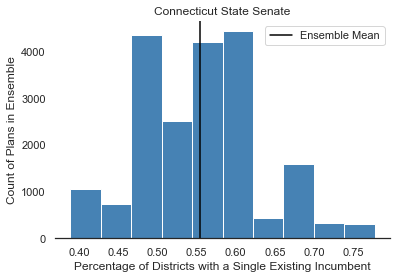

In [101]:
plt.hist(incumbent_ensemble_sen_plot, bins=10, color="steelblue")
plt.axvline(x=np.mean(incumbent_ensemble_sen_plot),color="black", label="Ensemble Mean")
plt.legend(loc="upper right")
plt.title("Connecticut State Senate")
plt.xlabel("Percentage of Districts with a Single Existing Incumbent")
plt.ylabel("Count of Plans in Ensemble")
sns.despine(left=True, right=True)
plt.savefig("./outputs/ct_senate_incumbents.png", dpi=300, facecolor='white', transparent=False)
plt.show()

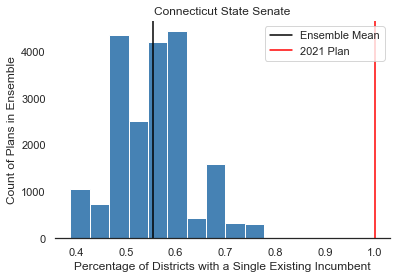

In [102]:
plt.hist(incumbent_ensemble_sen_plot, bins=10, color="steelblue")
plt.axvline(x=np.mean(incumbent_ensemble_sen_plot),color="black", label="Ensemble Mean")
plt.axvline(x=1,color="red", label="2021 Plan")
plt.legend(loc="upper right")
plt.title("Connecticut State Senate")
plt.xlabel("Percentage of Districts with a Single Existing Incumbent")
plt.ylabel("Count of Plans in Ensemble")
sns.despine(left=True, right=True)
plt.savefig("./outputs/ct_senate_incumbents_w2021.png", dpi=300, facecolor='white', transparent=False)
plt.show()

In [103]:
np.mean(splits_ensemble_sen)

35.9287

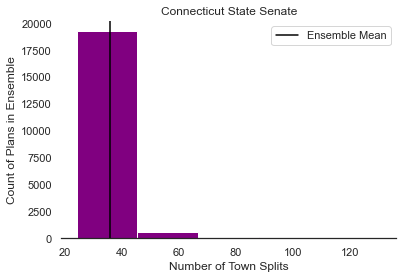

In [104]:
plt.hist(splits_ensemble_sen, bins=5, color="purple")
plt.axvline(x=np.mean(splits_ensemble_sen),color="black", label="Ensemble Mean")
plt.legend(loc="upper right")
plt.title("Connecticut State Senate")
plt.xlabel("Number of Town Splits")
plt.ylabel("Count of Plans in Ensemble")
sns.despine(left=True, right=True)
plt.savefig("./outputs/ct_senate_town.png", dpi=300, facecolor='white', transparent=False)
plt.show()

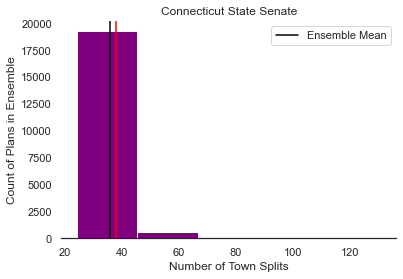

In [105]:
plt.hist(splits_ensemble_sen, bins=5, color="purple")
plt.axvline(x=np.mean(splits_ensemble_sen),color="black", label="Ensemble Mean")
plt.axvline(x=38,color="red")
plt.legend(loc="upper right")
plt.title("Connecticut State Senate")
plt.xlabel("Number of Town Splits")
plt.ylabel("Count of Plans in Ensemble")
sns.despine(left=True, right=True)
plt.savefig("./outputs/ct_senate_town_w2021.png", dpi=300, facecolor='white', transparent=False)
plt.show()